In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os

## Bài 1: So sánh và phân tích các bộ lọc làm mờ

1.1 Cài đặt các bộ lọc

In [2]:
def mean_filter(image, kernel_size):
    blur = cv2.blur(image, (kernel_size, kernel_size))
    return blur

In [3]:
def gaussian_filter(image, kernel_size, sigma):
    blur = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    return blur

In [4]:
def median_filter(image, kernel_size):
    blur = cv2.medianBlur(image, kernel_size)
    return blur

In [5]:
def bilateral_filter(image, d, sigma_color, sigma_space):
    blur = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return blur

1.2 Tạo nhiễu

In [6]:
def gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_img = image.astype(np.float32) + noise   
    noisy_img = np.clip(noisy_img, 0, 255)         
    noisy_img = noisy_img.astype(np.uint8)
    return noisy_img

In [7]:
def salt_and_pepper_noise(image, prob=0.01):
    noisy_img = np.copy(image)
    rnd = np.random.rand(*image.shape)
    noisy_img[rnd < (prob / 2)] = 0
    noisy_img[rnd > 1 - (prob / 2)] = 255

    return noisy_img 

1.3 Đánh giá bằng các chỉ số(PSNR, SSIM)

In [8]:
def psnr(original, denoised):
    original = original.astype(np.float64)
    denoised = denoised.astype(np.float64)
    mse = np.mean((original - denoised)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


In [9]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [10]:
def evaluate_filters(original, filtered):
    """Tính PSNR và SSIM"""
    psnr_value = psnr(original, filtered)
    ssim_value = ssim(original, filtered)
    return psnr_value, ssim_value

def compare_blur_filters(image_path):
    """So sánh các bộ lọc làm mờ"""
    # Load ảnh
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Tạo nhiễu
    noisy_gaussian = gaussian_noise(img)
    noisy_sp = salt_and_pepper_noise(img)
    
    # Áp dụng các bộ lọc
    
    
    results = {}
    
    # Test trên nhiễu Gaussian
    results['gaussian_noise'] = {
        'mean': mean_filter(noisy_gaussian, 5),
        'gaussian': gaussian_filter(noisy_gaussian, 5, 1.0),
        'median': median_filter(noisy_gaussian, 5),
        'bilateral': bilateral_filter(noisy_gaussian, 9, 75, 75)
    }
    
    # Test trên nhiễu Salt & Pepper
    results['sp_noise'] = {
        'mean': mean_filter(noisy_sp, 5),
        'gaussian': gaussian_filter(noisy_sp, 5, 1.0),
        'median': median_filter(noisy_sp, 5),
        'bilateral': bilateral_filter(noisy_sp, 9, 75, 75)
    }
    
    # Đánh giá
    for noise_type in results:
        print(f"\n{noise_type.upper()} Results:")
        for filter_name, filtered_img in results[noise_type].items():
            psnr_val, ssim_val = evaluate_filters(img, filtered_img)
            print(f"{filter_name}: PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}")
    
    return results

In [11]:
test1 = compare_blur_filters('anh_demo\\img1.jpg')
test2 = compare_blur_filters('anh_demo\\img2.jpg')


GAUSSIAN_NOISE Results:
mean: PSNR=22.37, SSIM=0.6343
gaussian: PSNR=25.20, SSIM=0.7576
median: PSNR=22.93, SSIM=0.6264
bilateral: PSNR=23.98, SSIM=0.6971

SP_NOISE Results:
mean: PSNR=22.65, SSIM=0.6622
gaussian: PSNR=26.09, SSIM=0.8268
median: PSNR=23.76, SSIM=0.7372
bilateral: PSNR=23.10, SSIM=0.6328

GAUSSIAN_NOISE Results:
mean: PSNR=29.24, SSIM=0.7702
gaussian: PSNR=29.71, SSIM=0.6859
median: PSNR=28.83, SSIM=0.7069
bilateral: PSNR=29.79, SSIM=0.7897

SP_NOISE Results:
mean: PSNR=30.39, SSIM=0.8616
gaussian: PSNR=32.79, SSIM=0.8799
median: PSNR=32.20, SSIM=0.9280
bilateral: PSNR=28.82, SSIM=0.8066


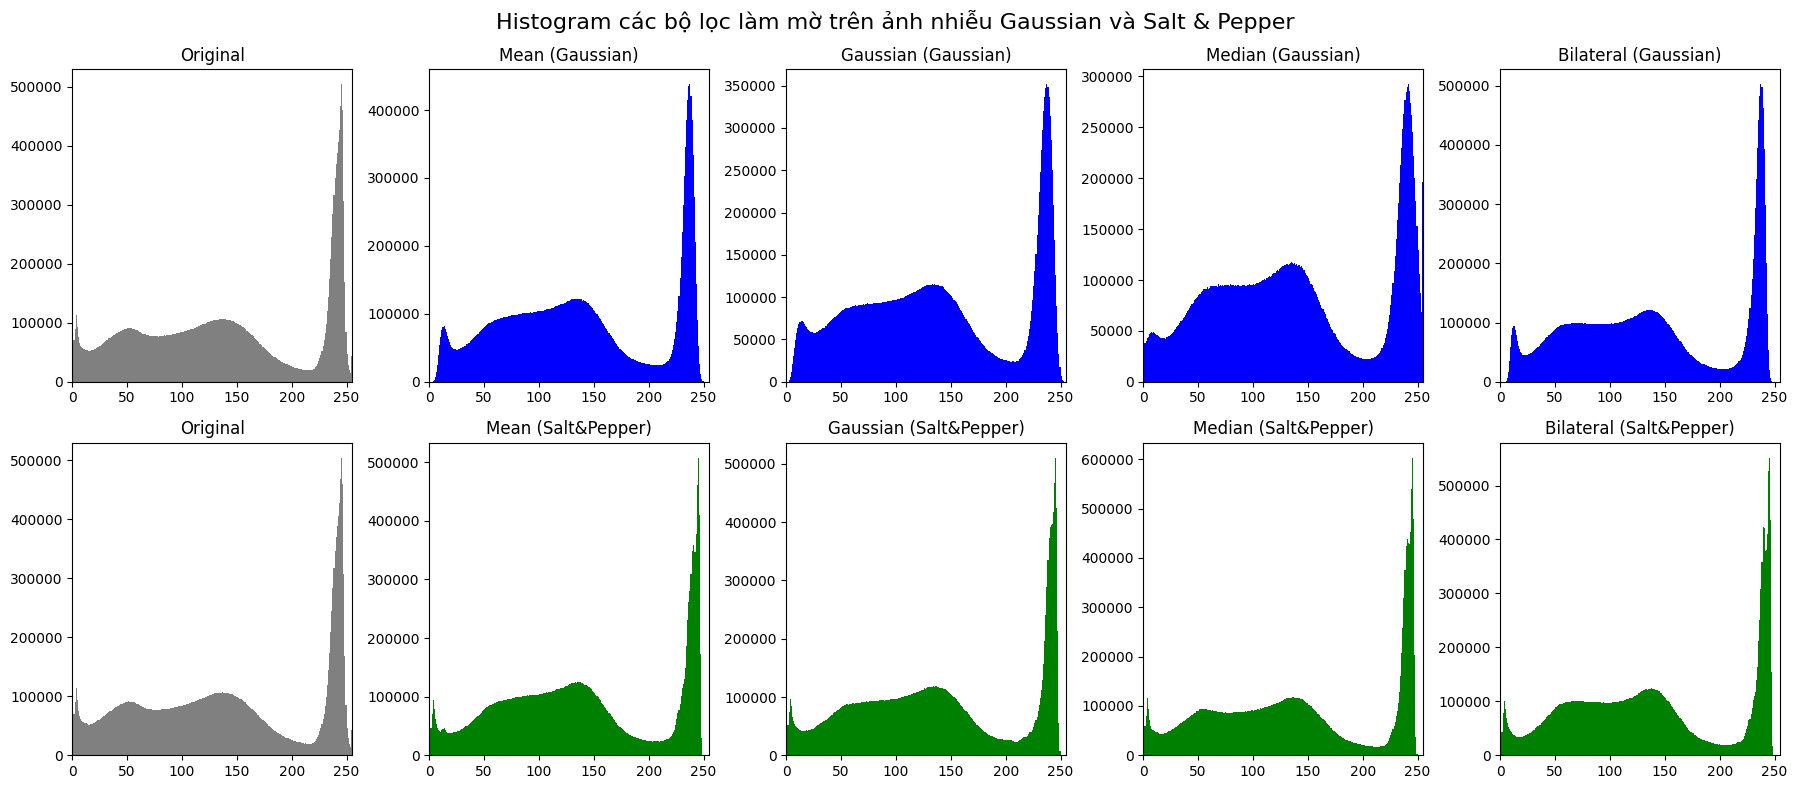

In [12]:
# Hiển thị histogram của ảnh sau khi lọc với từng loại nhiễu và filter
def show_blur_histograms(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    noisy_gaussian = gaussian_noise(img)
    noisy_sp = salt_and_pepper_noise(img)

    filters = {
        'Mean': mean_filter,
        'Gaussian': lambda im: gaussian_filter(im, 5, 1.0),
        'Median': median_filter,
        'Bilateral': lambda im: bilateral_filter(im, 9, 75, 75)
    }

    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    fig.suptitle('Histogram các bộ lọc làm mờ trên ảnh nhiễu Gaussian và Salt & Pepper', fontsize=16)

    # Histogram ảnh gốc
    axes[0, 0].hist(img.ravel(), bins=256, range=(0,255), color='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].set_xlim([0,255])

    axes[1, 0].hist(img.ravel(), bins=256, range=(0,255), color='gray')
    axes[1, 0].set_title('Original')
    axes[1, 0].set_xlim([0,255])

    # Histogram các filter trên Gaussian noise
    for col, (name, func) in enumerate(filters.items(), start=1):
        filtered_g = func(noisy_gaussian, 5) if name != 'Gaussian' and name != 'Bilateral' else func(noisy_gaussian)
        axes[0, col].hist(filtered_g.ravel(), bins=256, range=(0,255), color='blue')
        axes[0, col].set_title(f'{name} (Gaussian)')
        axes[0, col].set_xlim([0,255])

        filtered_sp = func(noisy_sp, 5) if name != 'Gaussian' and name != 'Bilateral' else func(noisy_sp)
        axes[1, col].hist(filtered_sp.ravel(), bins=256, range=(0,255), color='green')
        axes[1, col].set_title(f'{name} (Salt&Pepper)')
        axes[1, col].set_xlim([0,255])

    plt.tight_layout()
    plt.show()

# Gọi hàm hiển thị histogram
show_blur_histograms('anh_demo\\img1.jpg')

## Bài 2: Edge detection 

In [13]:
def sobel_filter(image):
        """Bộ lọc Sobel"""
        # Sobel kernels
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        
        # Áp dụng convolution
        grad_x = cv2.filter2D(image, cv2.CV_64F, sobel_x)
        grad_y = cv2.filter2D(image, cv2.CV_64F, sobel_y)
        
        # Tính magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        magnitude = np.uint8(np.clip(magnitude, 0, 255))
        
        return magnitude

In [14]:
def prewitt_filter(image):
        """Bộ lọc prewitt"""
        # prewitt kernels
        prewitt_x = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
        prewitt_y = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        
        # Áp dụng convolution
        grad_x = cv2.filter2D(image, cv2.CV_64F, prewitt_x)
        grad_y = cv2.filter2D(image, cv2.CV_64F, prewitt_y)
        
        # Tính magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        magnitude = np.uint8(np.clip(magnitude, 0, 255))
        
        return magnitude

In [15]:
def laplacian_filter(image):
        """Bộ lọc Laplacian"""
        laplacian_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
        
        laplacian = cv2.filter2D(image, cv2.CV_64F, laplacian_kernel)
        laplacian = np.uint8(np.clip(np.abs(laplacian), 0, 255))
        
        return laplacian

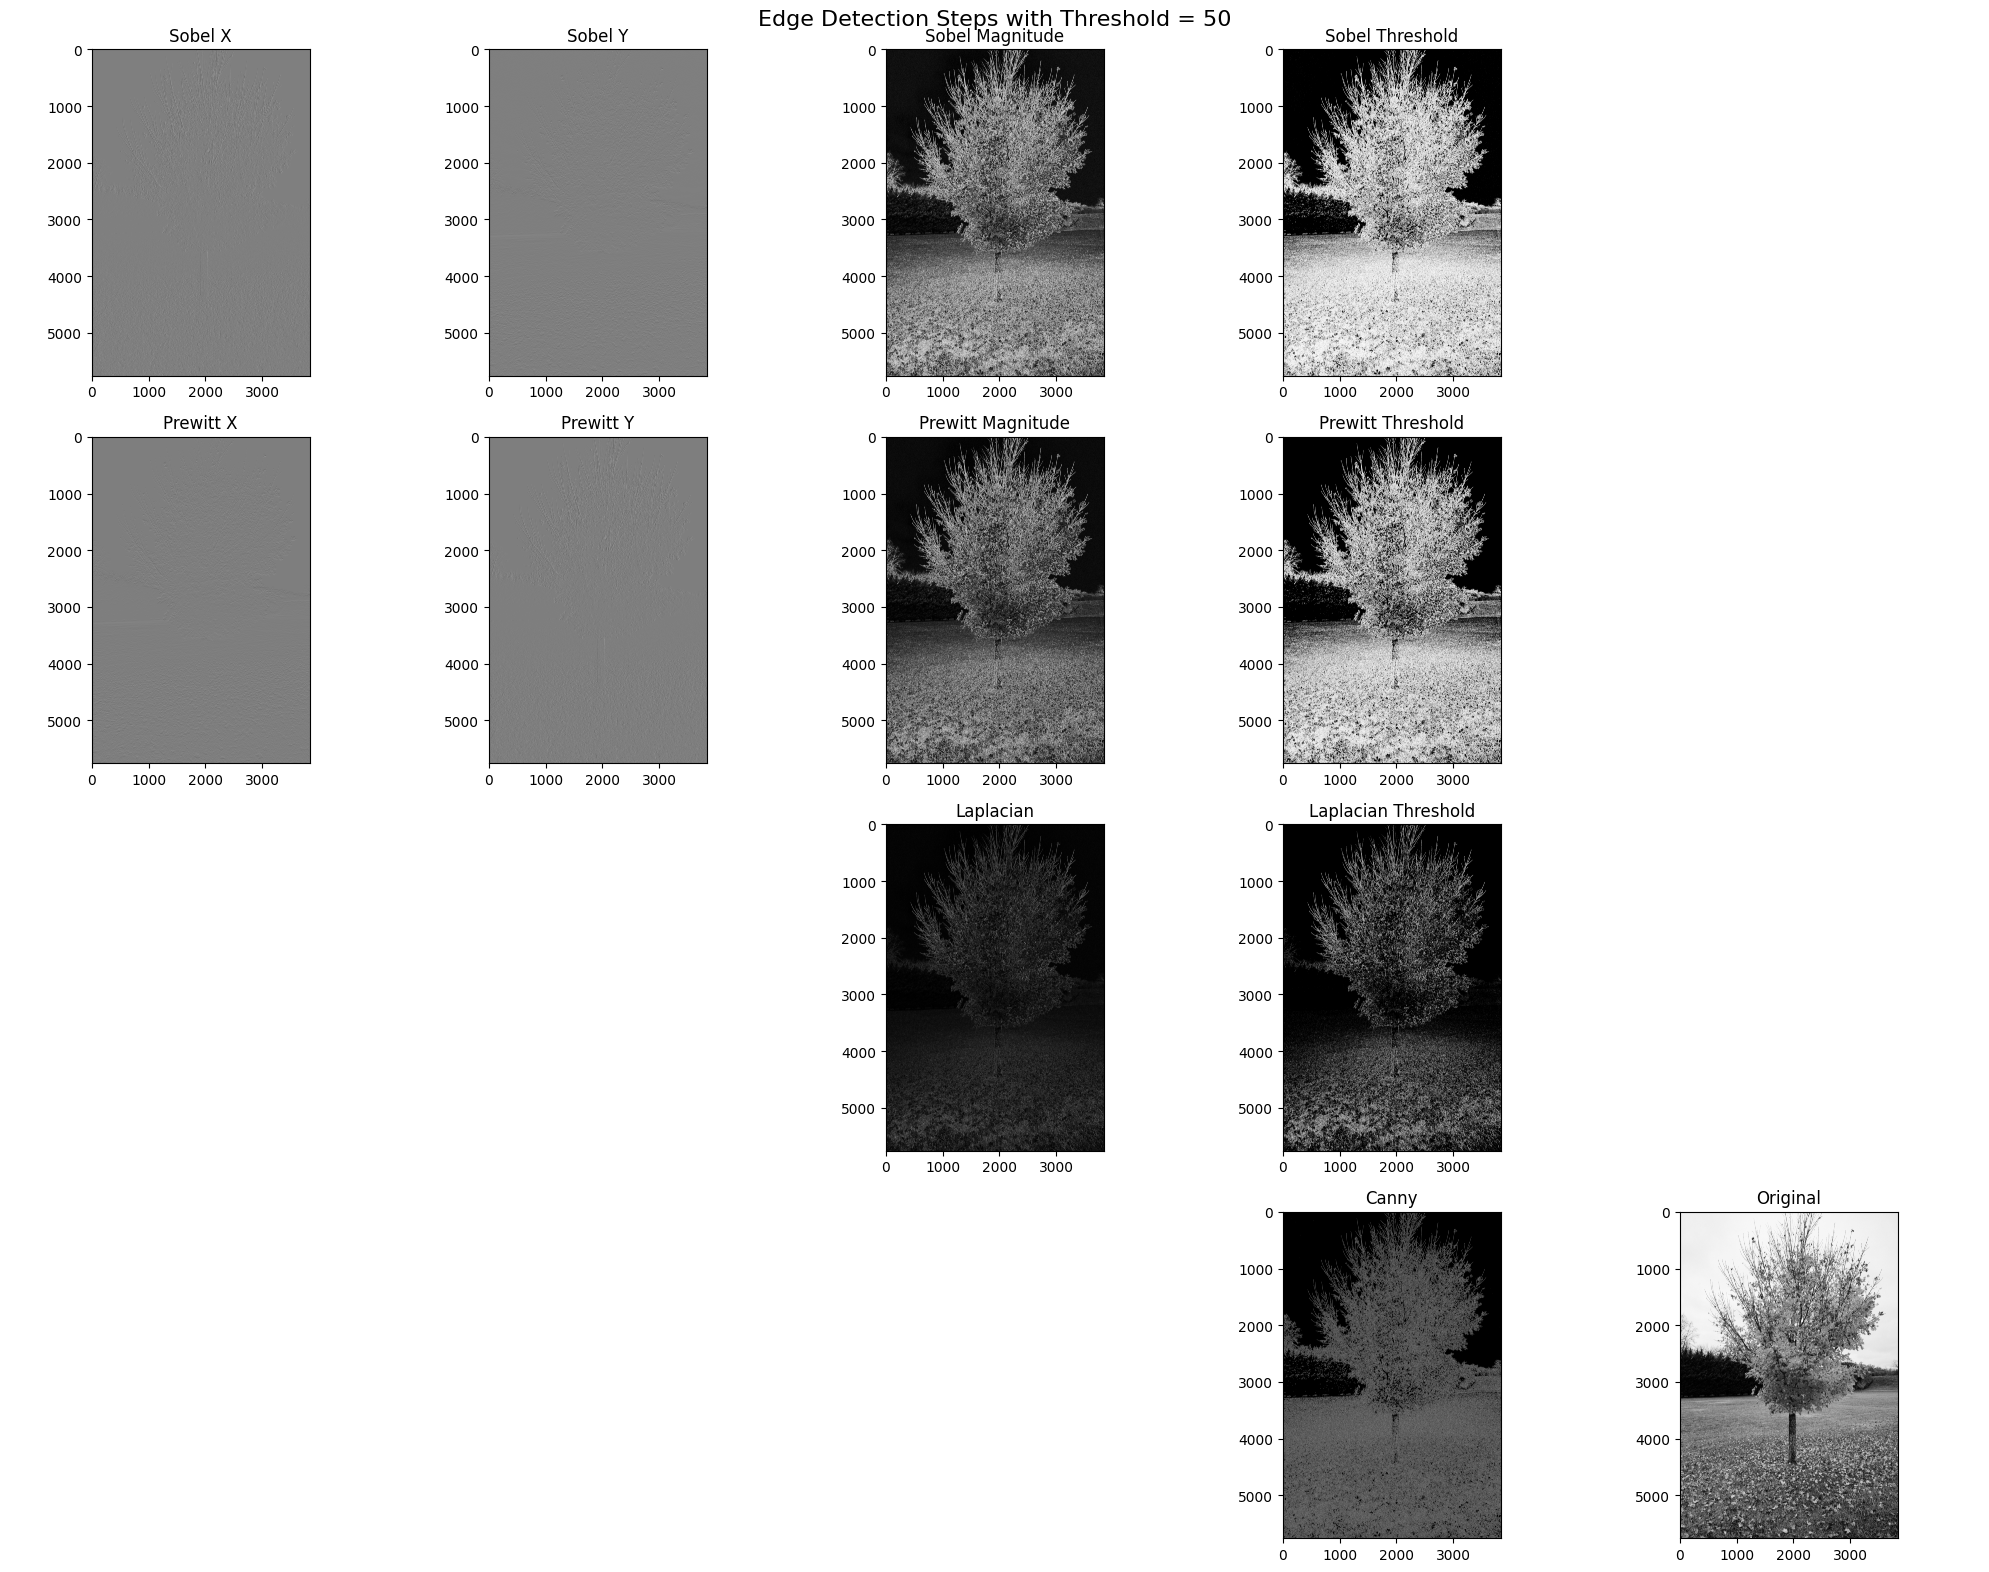

In [16]:
def illustrate_edge_detection_steps(image_path, threshold=100):
    """Minh họa các bước trong phát hiện biên với ngưỡng"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Sobel
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = cv2.magnitude(sobel_x, sobel_y)
    sobel_mag = np.uint8(np.clip(sobel_mag, 0, 255))
    _, sobel_thresh = cv2.threshold(sobel_mag, threshold, 255, cv2.THRESH_BINARY)
    
    # Prewitt
    prewitt_x = cv2.filter2D(img, cv2.CV_64F, np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))
    prewitt_y = cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
    prewitt_mag = cv2.magnitude(prewitt_x, prewitt_y)
    prewitt_mag = np.uint8(np.clip(prewitt_mag, 0, 255))
    _, prewitt_thresh = cv2.threshold(prewitt_mag, threshold, 255, cv2.THRESH_BINARY)
    
    # Laplacian
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    laplacian = np.uint8(np.clip(np.abs(laplacian), 0, 255))
    _, laplacian_thresh = cv2.threshold(laplacian, threshold, 255, cv2.THRESH_BINARY)
    
    # Canny
    canny = cv2.Canny(img, threshold, threshold * 2)
    
    # Visualize
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    fig.suptitle(f'Edge Detection Steps with Threshold = {threshold}', fontsize=16)
    
    # Row 1: Sobel
    axes[0,0].imshow(sobel_x, cmap='gray')
    axes[0,0].set_title('Sobel X')
    axes[0,1].imshow(sobel_y, cmap='gray')
    axes[0,1].set_title('Sobel Y')
    axes[0,2].imshow(sobel_mag, cmap='gray')
    axes[0,2].set_title('Sobel Magnitude')
    axes[0,3].imshow(sobel_thresh, cmap='gray')
    axes[0,3].set_title('Sobel Threshold')
    axes[0,4].axis('off')
    
    # Row 2: Prewitt
    axes[1,0].imshow(prewitt_x, cmap='gray')
    axes[1,0].set_title('Prewitt X')
    axes[1,1].imshow(prewitt_y, cmap='gray')
    axes[1,1].set_title('Prewitt Y')
    axes[1,2].imshow(prewitt_mag, cmap='gray')
    axes[1,2].set_title('Prewitt Magnitude')
    axes[1,3].imshow(prewitt_thresh, cmap='gray')
    axes[1,3].set_title('Prewitt Threshold')
    axes[1,4].axis('off')
    
    # Row 3: Laplacian
    axes[2,0].axis('off')
    axes[2,1].axis('off')
    axes[2,2].imshow(laplacian, cmap='gray')
    axes[2,2].set_title('Laplacian')
    axes[2,3].imshow(laplacian_thresh, cmap='gray')
    axes[2,3].set_title('Laplacian Threshold')
    axes[2,4].axis('off')
    
    # Row 4: Canny
    axes[3,0].axis('off')
    axes[3,1].axis('off')
    axes[3,2].axis('off')
    axes[3,3].imshow(canny, cmap='gray')
    axes[3,3].set_title('Canny')
    axes[3,4].imshow(img, cmap='gray')
    axes[3,4].set_title('Original')
    
    plt.tight_layout()
    plt.show()



# Gọi hàm minh họa
illustrate_edge_detection_steps('anh_demo\\img1.jpg', threshold=50)



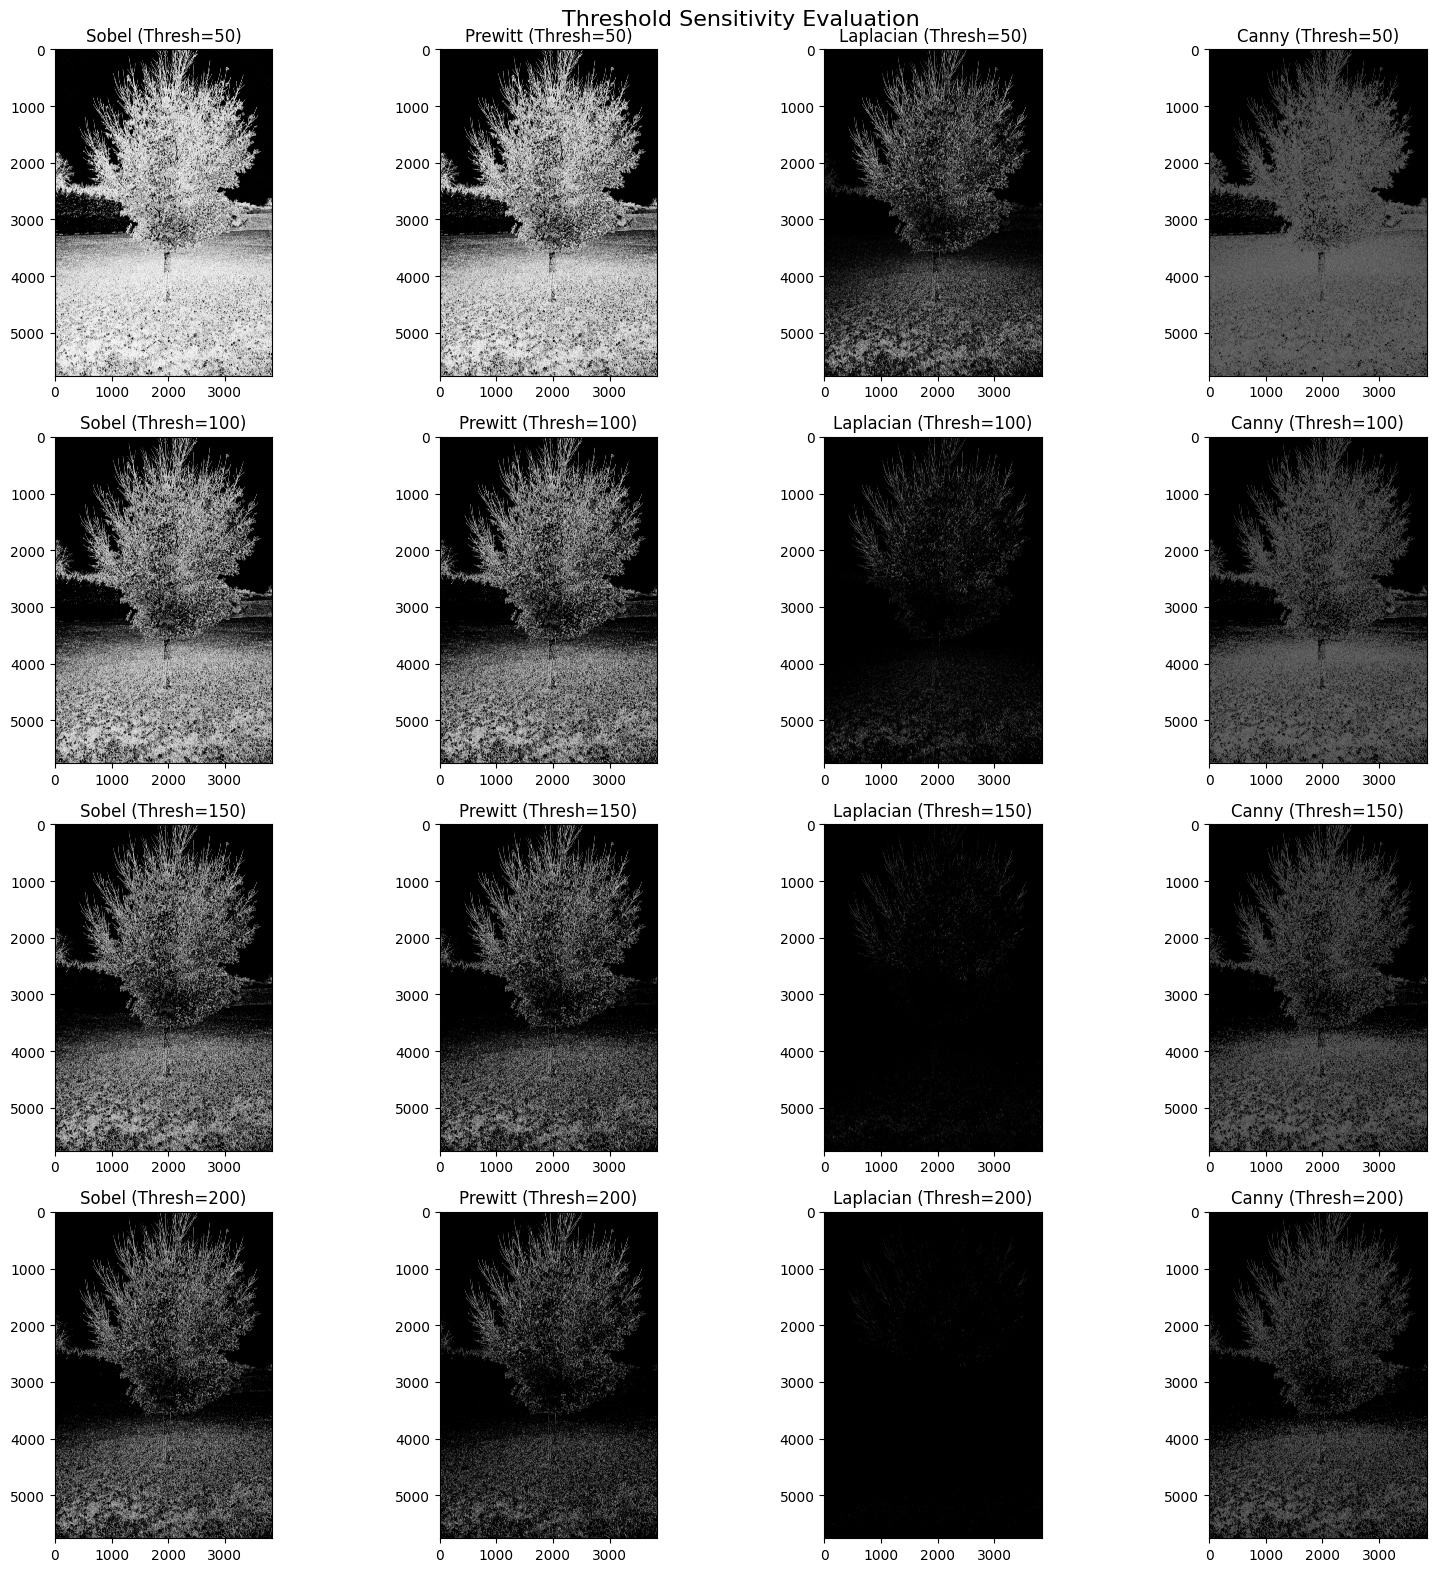

In [17]:
def evaluate_threshold_sensitivity(image_path, thresholds=[50, 100, 150, 200]):
    """Đánh giá độ nhạy của tham số ngưỡng"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    fig, axes = plt.subplots(len(thresholds), 4, figsize=(16, 4*len(thresholds)))
    fig.suptitle('Threshold Sensitivity Evaluation', fontsize=16)
    
    for i, thresh in enumerate(thresholds):
        # Sobel
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        sobel_mag = cv2.magnitude(sobel_x, sobel_y)
        sobel_mag = np.uint8(np.clip(sobel_mag, 0, 255))
        _, sobel_thresh = cv2.threshold(sobel_mag, thresh, 255, cv2.THRESH_BINARY)
        
        # Prewitt
        prewitt_x = cv2.filter2D(img, cv2.CV_64F, np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))
        prewitt_y = cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
        prewitt_mag = cv2.magnitude(prewitt_x, prewitt_y)
        prewitt_mag = np.uint8(np.clip(prewitt_mag, 0, 255))
        _, prewitt_thresh = cv2.threshold(prewitt_mag, thresh, 255, cv2.THRESH_BINARY)
        
        # Laplacian
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        laplacian = np.uint8(np.clip(np.abs(laplacian), 0, 255))
        _, laplacian_thresh = cv2.threshold(laplacian, thresh, 255, cv2.THRESH_BINARY)
        
        # Canny
        canny = cv2.Canny(img, thresh, thresh * 2)
        
        axes[i,0].imshow(sobel_thresh, cmap='gray')
        axes[i,0].set_title(f'Sobel (Thresh={thresh})')
        axes[i,1].imshow(prewitt_thresh, cmap='gray')
        axes[i,1].set_title(f'Prewitt (Thresh={thresh})')
        axes[i,2].imshow(laplacian_thresh, cmap='gray')
        axes[i,2].set_title(f'Laplacian (Thresh={thresh})')
        axes[i,3].imshow(canny, cmap='gray')
        axes[i,3].set_title(f'Canny (Thresh={thresh})')
    
    plt.tight_layout()
    plt.show()


# Gọi hàm đánh giá độ nhạy
evaluate_threshold_sensitivity('anh_demo\\img1.jpg')

## Bài 3: Tăng cường ảnh (Image enhancement)

In [18]:
def laplacian_filter(image, alpha=1.5):
    laplacian_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    laplacian = cv2.filter2D(image, cv2.CV_64F, laplacian_kernel)
    
    sharpened = image.astype(np.float64) + alpha * laplacian
    return np.uint8(np.clip(sharpened, 0, 255))

In [19]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Subtract the blurred image from the original
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

In [20]:
def histogram_equalization(image):
    """Cân bằng histogram"""
    return cv2.equalizeHist(image)

In [21]:
def enhance_image_workflow(image_path):
    """Workflow tăng cường ảnh"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Bước 1: Khử nhiễu nhẹ
    denoised = cv2.GaussianBlur(img, (5, 5), 1.0)
    
    # Bước 2: Cân bằng histogram
    equalized = histogram_equalization(denoised)
    
    # Bước 3: Làm sắc nét
    sharpened = unsharp_mask(equalized)
    
    # Visualize các bước
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original')
    
    axes[0,1].imshow(denoised, cmap='gray')
    axes[0,1].set_title('Denoised')
    
    axes[1,0].imshow(equalized, cmap='gray')
    axes[1,0].set_title('Histogram Equalized')
    
    axes[1,1].imshow(sharpened, cmap='gray')
    axes[1,1].set_title('Final Enhanced')
    
    plt.tight_layout()
    plt.show()
    


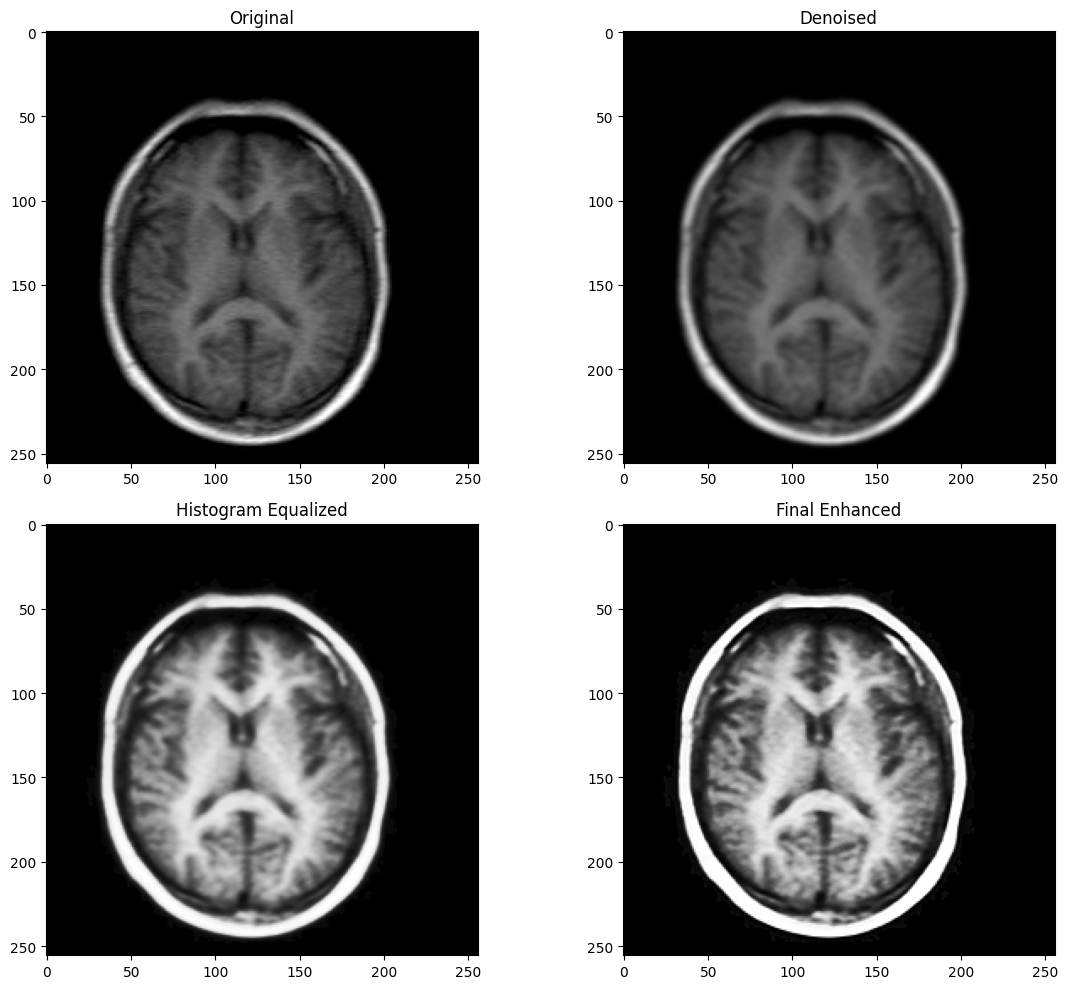

In [22]:
test3 = enhance_image_workflow('C:\CS\image_processing\Tieu_Luan_2\ST000001\IM000009.jpg')

## Bài 4: Bộ lọc trong xử lí ảnh y tế

In [23]:
def process_medical_image( img):
    """Xử lý ảnh y tế"""
    # Bước 1: Khử nhiễu bằng Gaussian
    denoised = cv2.GaussianBlur(img, (5, 5), 1)
    
    # Bước 2: Tăng cường tương phản
    enhanced = cv2.equalizeHist(denoised)
    
    # Bước 3: Phát hiện biên bằng Sobel
    sobel_x = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
        
    # Bước 4: Phát hiện biên bằng Canny
    canny_edges = cv2.Canny(enhanced, 30, 100)
    
    return {
        
        'denoised': denoised,
        'enhanced': enhanced,
        'sobel_edges': sobel_combined,
        'canny_edges': canny_edges
    }
    
def analyze_medical_results(results):
    """Phân tích kết quả"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].imshow(results['denoised'], cmap='gray')
    axes[0,0].set_title('Gaussian Denoised')
    
    axes[0,1].imshow(results['enhanced'], cmap='gray')
    axes[0,1].set_title('Contrast Enhanced')
    
    axes[1, 0].imshow(results['sobel_edges'], cmap='gray')
    axes[1, 0].set_title('Sobel Edge Detection')

    axes[1, 1].imshow(results['canny_edges'], cmap='gray')
    axes[1, 1].set_title('Canny Edge Detection')

    plt.tight_layout()
    plt.show()

In [24]:
def get_random_image(folder_path):
    # Liệt kê tất cả file trong thư mục
    all_files = os.listdir(folder_path)
    
    # Lọc ra chỉ file hình ảnh (có thể thêm các định dạng khác nếu cần)
    image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        raise ValueError("Không có file hình ảnh trong thư mục.")
    
    # Chọn ngẫu nhiên một file
    random_file = random.choice(image_files)
    
    # Đọc hình ảnh
    image_path = os.path.join(folder_path, random_file)
    img = cv2.imread(image_path)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_image, random_file

# Ví dụ sử dụng
folder_path = r'Alzheimers_Detection_dataset\train'  
random_img_al, filename_al = get_random_image(folder_path)
print(f"Đã chọn hình: {filename_al}")

Đã chọn hình: VMD__2055_jpg.rf.64e7d9b231a7f48daff3df6dba943144.jpg


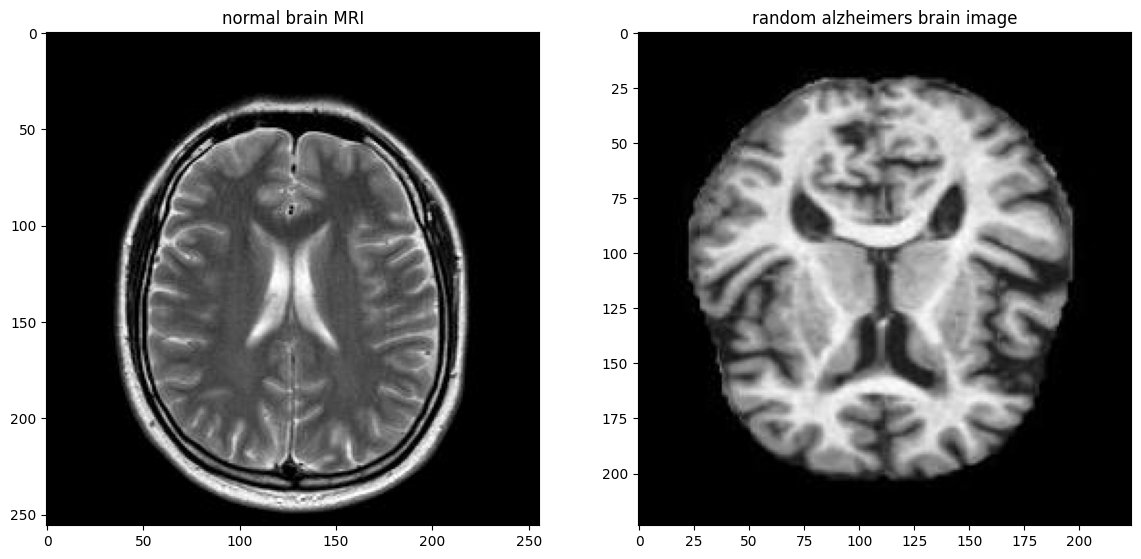

In [25]:
folder_path = r'ST000001'  
random_img_normal, filename_normal = get_random_image(folder_path)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(random_img_normal, cmap='gray')
axes[0].set_title('normal brain MRI')
axes[1].imshow(random_img_al, cmap='gray')
axes[1].set_title('random alzheimers brain image')
plt.show()

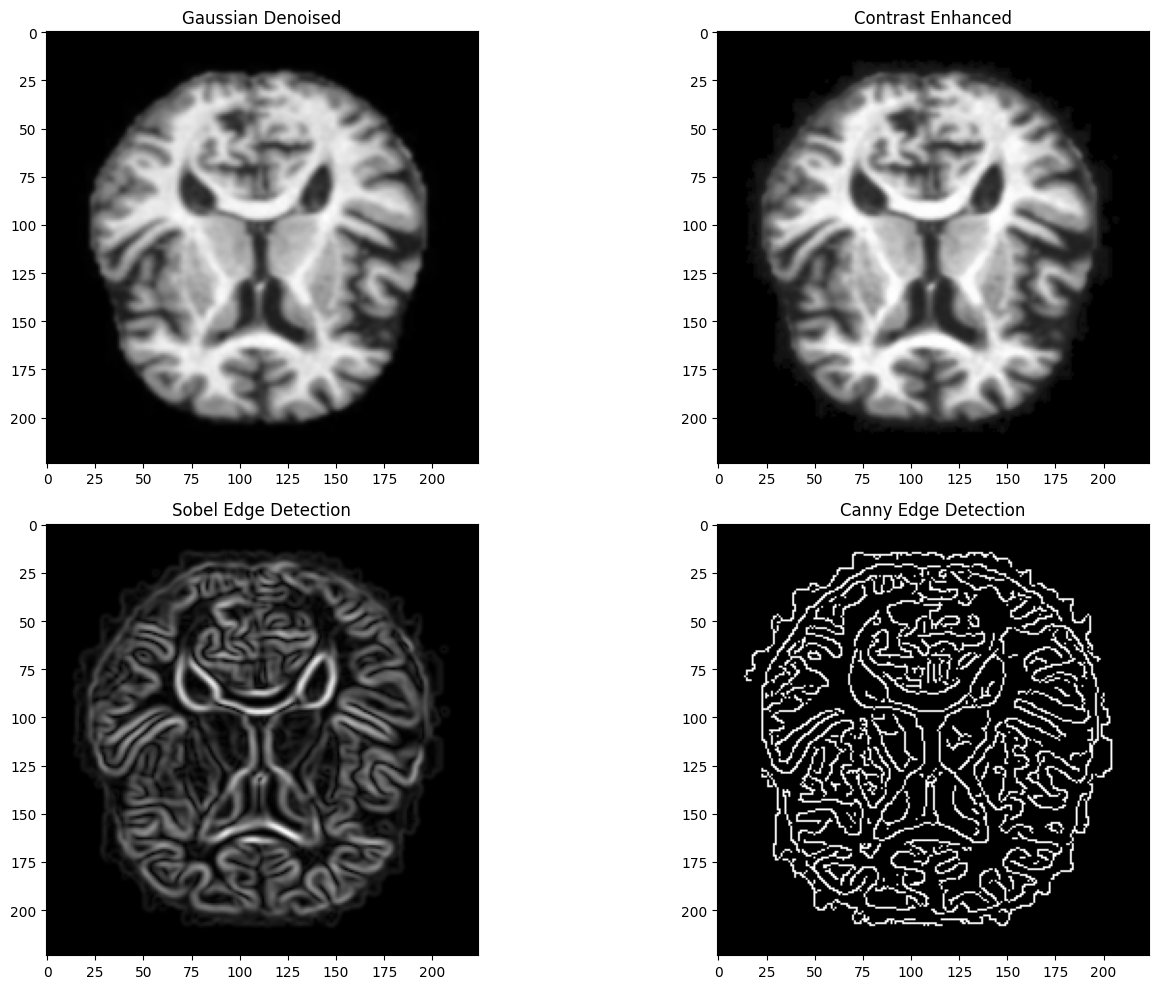

In [26]:
rs = process_medical_image(random_img_al)
rs1 = analyze_medical_results(rs)

In [27]:
def sobel(img1, img2):
    sobel_x1 = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y1 = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined1 = cv2.magnitude(sobel_x1, sobel_y1)

    sobel_x2 = cv2.Sobel(img2, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y2 = cv2.Sobel(img2, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined2 = cv2.magnitude(sobel_x2, sobel_y2)

    return sobel_combined1, sobel_combined2

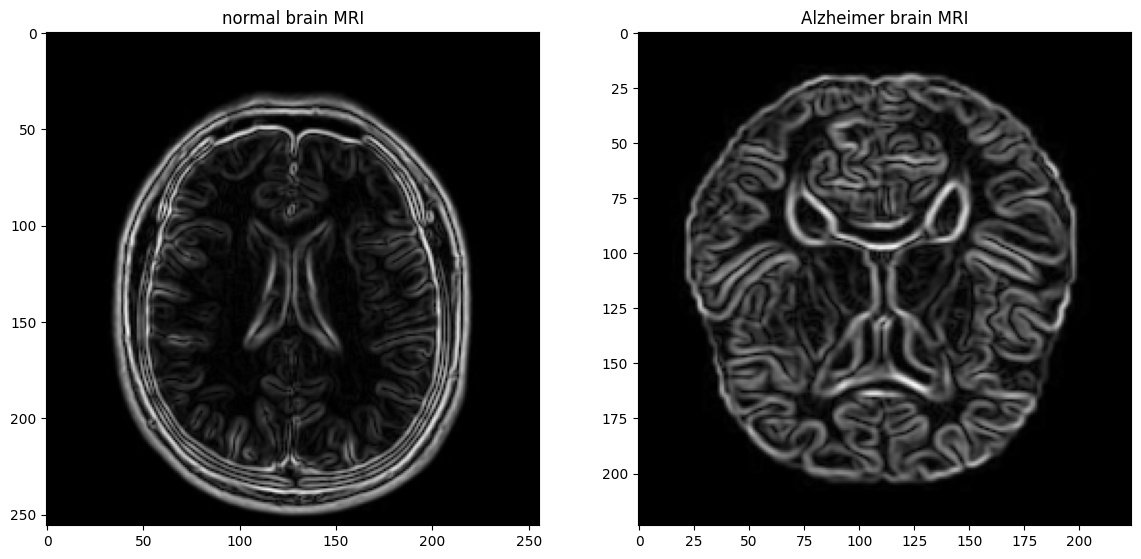

In [28]:
norm_brain, alzhemer_brain = sobel(random_img_normal, random_img_al)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(norm_brain, cmap='gray')
axes[0].set_title('normal brain MRI')
axes[1].imshow(alzhemer_brain, cmap='gray')
axes[1].set_title('Alzheimer brain MRI')
plt.show()

## Bài 5: Ứng dụng thực tế: Mini photo editor


In [29]:
import tkinter as tk
from PIL import Image, ImageTk
from tkinter import filedialog, messagebox, ttk

In [30]:
class PhotoEditor:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("Mini Photo Editor")
        self.root.geometry("1200x750")
        self.root.configure(bg='#1e1e1e')
        
       
        self.setup_styles()
        
        self.image = None
        self.processed_image = None
        self.photo_label = None
        
        self.setup_ui()
        
    def setup_styles(self):
        
        self.style = ttk.Style()
        self.style.theme_use('clam')
        
        
        self.bg_color = '#1e1e1e'
        self.card_color = '#2d2d2d'
        self.accent_color = '#007acc'
        self.text_color = '#ffffff'
        self.button_hover = '#0d5fa3'
        
        # Configure ttk styles
        self.style.configure('Modern.TFrame', background=self.card_color, relief='flat')
        self.style.configure('Card.TLabelFrame', background=self.card_color, foreground=self.text_color,
                           borderwidth=2, relief='raised')
        self.style.configure('Card.TLabelFrame.Label', background=self.card_color, foreground=self.text_color,
                           font=('Segoe UI', 10, 'bold'))
        
    def create_modern_button(self, parent, text, command, bg_color=None, width=12, height=1):
        
        if bg_color is None:
            bg_color = self.accent_color
            
        btn = tk.Button(
            parent,
            text=text,
            command=command,
            bg=bg_color,
            fg='white',
            font=('Segoe UI', 9, 'bold'),
            relief='flat',
            borderwidth=0,
            cursor='hand2',
            width=width,
            height=height,
            activebackground=self.button_hover,
            activeforeground='white'
        )
        
        # hover
        def on_enter(e):
            btn.configure(bg=self.button_hover)
        def on_leave(e):
            btn.configure(bg=bg_color)
            
        btn.bind("<Enter>", on_enter)
        btn.bind("<Leave>", on_leave)
        
        return btn
        
    def setup_ui(self):
        
        
        main_container = tk.Frame(self.root, bg=self.bg_color)
        main_container.pack(fill=tk.BOTH, expand=True, padx=15, pady=15)
        
        # Header
        header_frame = tk.Frame(main_container, bg=self.bg_color, height=50)
        header_frame.pack(fill=tk.X, pady=(0, 10))
        header_frame.pack_propagate(False)
        
        title_label = tk.Label(
            header_frame,
            text="Mini Photo Editor",
            font=('Segoe UI', 20, 'bold'),
            fg='#ffffff',
            bg=self.bg_color
        )
        title_label.pack(pady=10)
        
        # Control panel
        control_panel = tk.Frame(main_container, bg=self.card_color, relief='raised', bd=2)
        control_panel.pack(fill=tk.X, pady=(0, 15))
        
        # File operations
        file_frame = tk.Frame(control_panel, bg=self.card_color)
        file_frame.pack(side=tk.LEFT, padx=20, pady=15)
        
        tk.Label(file_frame, text="📁 File Operations", font=('Segoe UI', 12, 'bold'),
                fg=self.text_color, bg=self.card_color).pack(anchor='w', pady=(0, 8))
        
        file_btn_frame = tk.Frame(file_frame, bg=self.card_color)
        file_btn_frame.pack()
        
        self.create_modern_button(file_btn_frame, "📂 Load Image", self.load_image, '#28a745').pack(side=tk.LEFT, padx=5)
        self.create_modern_button(file_btn_frame, "💾 Save Image", self.save_image, '#dc3545').pack(side=tk.LEFT, padx=5)
        
        # Parameters
        param_frame = tk.Frame(control_panel, bg=self.card_color)
        param_frame.pack(side=tk.RIGHT, padx=20, pady=15)
        
        tk.Label(param_frame, text="⚙️ Parameters", font=('Segoe UI', 12, 'bold'),
                fg=self.text_color, bg=self.card_color).pack(anchor='w', pady=(0, 8))
        
        param_controls = tk.Frame(param_frame, bg=self.card_color)
        param_controls.pack()
        
        # Kernel size
        kernel_frame = tk.Frame(param_controls, bg=self.card_color)
        kernel_frame.pack(side=tk.LEFT, padx=10)
        
        tk.Label(kernel_frame, text="Kernel Size:", font=('Segoe UI', 9),
                fg=self.text_color, bg=self.card_color).pack()
        
        self.kernel_var = tk.IntVar(value=5)
        kernel_scale = tk.Scale(
            kernel_frame, from_=3, to=15, orient=tk.HORIZONTAL,
            variable=self.kernel_var, resolution=2,
            bg=self.card_color, fg=self.text_color, highlightthickness=0,
            troughcolor=self.accent_color, activebackground=self.button_hover,
            font=('Segoe UI', 8)
        )
        kernel_scale.pack()
        
        # Sigma
        sigma_frame = tk.Frame(param_controls, bg=self.card_color)
        sigma_frame.pack(side=tk.LEFT, padx=10)
        
        tk.Label(sigma_frame, text="Sigma:", font=('Segoe UI', 9),
                fg=self.text_color, bg=self.card_color).pack()
        
        self.sigma_var = tk.DoubleVar(value=1.0)
        sigma_scale = tk.Scale(
            sigma_frame, from_=0.1, to=5.0, orient=tk.HORIZONTAL,
            variable=self.sigma_var, resolution=0.1,
            bg=self.card_color, fg=self.text_color, highlightthickness=0,
            troughcolor=self.accent_color, activebackground=self.button_hover,
            font=('Segoe UI', 8)
        )
        sigma_scale.pack()
        
        
        content_frame = tk.Frame(main_container, bg=self.bg_color)
        content_frame.pack(fill=tk.BOTH, expand=True)
        
        
        sidebar = tk.Frame(content_frame, bg=self.card_color, width=280, relief='raised', bd=2)
        sidebar.pack(side=tk.LEFT, fill=tk.Y, padx=(0, 15))
        sidebar.pack_propagate(False)
        
        
        sidebar_title = tk.Label(
            sidebar,
            text="🎨 Filters & Effects",
            font=('Segoe UI', 16, 'bold'),
            fg=self.text_color,
            bg=self.card_color
        )
        sidebar_title.pack(pady=20)
        
        
        self.create_filter_section(sidebar, "🌫️ Blur Filters", [
            ("Mean Blur", self.apply_mean_blur),
            ("Gaussian Blur", self.apply_gaussian_blur),
            ("Median Blur", self.apply_median_blur),
            ("Bilateral Filter", self.apply_bilateral)
        ])
        
        self.create_filter_section(sidebar, "⚡ Sharpen Filters", [
            ("Laplacian Sharpen", self.apply_laplacian_sharpen),
            ("Unsharp Mask", self.apply_unsharp_mask)
        ])
        
        self.create_filter_section(sidebar, "🔍 Edge Detection", [
            ("Sobel", self.apply_sobel),
            ("Laplacian", self.apply_laplacian),
            ("Canny", self.apply_canny)
        ])
        
        
        self.image_container = tk.Frame(content_frame, bg=self.card_color, relief='raised', bd=2)
        self.image_container.pack(fill=tk.BOTH, expand=True)
        
        
        self.create_image_placeholder()
        
    def create_filter_section(self, parent, title, filters):
        
        section_frame = tk.Frame(parent, bg=self.card_color)
        section_frame.pack(fill=tk.X, padx=15, pady=10)
        
        
        title_label = tk.Label(
            section_frame,
            text=title,
            font=('Segoe UI', 12, 'bold'),
            fg=self.text_color,
            bg=self.card_color
        )
        title_label.pack(anchor='w', pady=(0, 8))
        
        
        for filter_name, command in filters:
            btn = self.create_modern_button(
                section_frame, 
                filter_name, 
                command,
                width=20,
                height=1
            )
            btn.pack(fill=tk.X, pady=2)
            
    def create_image_placeholder(self):
        
        placeholder_frame = tk.Frame(self.image_container, bg=self.card_color)
        placeholder_frame.pack(expand=True)
        
        placeholder_label = tk.Label(
            placeholder_frame,
            text="📷\n\nNo Image Loaded\n\nClick 'Load Image' to get started",
            font=('Segoe UI', 18),
            fg='#666666',
            bg=self.card_color,
            justify=tk.CENTER
        )
        placeholder_label.pack(expand=True)
        
    def load_image(self):
        """Load image from file"""
        file_path = filedialog.askopenfilename(
            title="Select an image",
            filetypes=[("Image files", "*.jpg *.jpeg *.png *.gif")]
        )
        if file_path:
            try:
                self.image = cv2.imread(file_path)
                if self.image is None:
                    messagebox.showerror("Error", "Could not load image. Please select a valid image file.")
                    return
                    
                self.processed_image = self.image.copy()
                self.display_image()
                messagebox.showinfo("Success", "Image loaded successfully!")
            except Exception as e:
                messagebox.showerror("Error", f"Error loading image: {str(e)}")
    
    def display_image(self):

        if self.processed_image is not None:
            for widget in self.image_container.winfo_children():
                widget.destroy()
                
            display_frame = tk.Frame(self.image_container, bg=self.card_color)
            display_frame.pack(expand=True, fill=tk.BOTH, padx=20, pady=20)
            
            img_rgb = cv2.cvtColor(self.processed_image, cv2.COLOR_BGR2RGB)
            
            height, width = img_rgb.shape[:2]
            max_size = 600
            if max(height, width) > max_size:
                scale = max_size / max(height, width)
                new_width = int(width * scale)
                new_height = int(height * scale)
                img_rgb = cv2.resize(img_rgb, (new_width, new_height))
            
            img_pil = Image.fromarray(img_rgb)
            photo = ImageTk.PhotoImage(img_pil)
            
            img_frame = tk.Frame(display_frame, bg='#ffffff', relief='raised', bd=3)
            img_frame.pack(expand=True)
            
            self.photo_label = tk.Label(img_frame, image=photo, bg='#ffffff')
            self.photo_label.image = photo  
            self.photo_label.pack(padx=5, pady=5)
            
            info_label = tk.Label(
                display_frame,
                text=f"Size: {img_rgb.shape[1]} x {img_rgb.shape[0]} pixels",
                font=('Segoe UI', 10),
                fg='#888888',
                bg=self.card_color
            )
            info_label.pack(pady=(10, 0))
    
    def apply_mean_blur(self):
        if self.image is not None:
            kernel_size = self.kernel_var.get()
            self.processed_image = cv2.blur(self.image, (kernel_size, kernel_size))
            self.display_image()

    def apply_median_blur(self):
        if self.image is not None:
            kernel_size = self.kernel_var.get()
            self.processed_image = cv2.medianBlur(self.image, kernel_size)
            self.display_image()
    
    def apply_gaussian_blur(self):
        if self.image is not None:
            kernel_size = self.kernel_var.get()
            sigma = self.sigma_var.get()
            self.processed_image = cv2.GaussianBlur(self.image, (kernel_size, kernel_size), sigma)
            self.display_image()
    
    def apply_bilateral(self):
        if self.image is not None:
            d = self.kernel_var.get()
            sigma_color = self.sigma_var.get() * 50
            sigma_space = self.sigma_var.get() * 50
            self.processed_image = cv2.bilateralFilter(self.image, d, sigma_color, sigma_space)
            self.display_image()

    def apply_laplacian_sharpen(self):
        if self.image is not None:
            gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
            laplacian = cv2.Laplacian(gray, cv2.CV_64F)
            sharpened = np.uint8(np.clip(gray - 0.5 * laplacian, 0, 255))
            self.processed_image = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)
            self.display_image()

    def apply_unsharp_mask(self):
        if self.image is not None:
            gaussian = cv2.GaussianBlur(self.image, (5, 5), 1.0)
            unsharp = cv2.addWeighted(self.image, 1.5, gaussian, -0.5, 0)
            self.processed_image = unsharp
            self.display_image()
    
    def apply_sobel(self):
        if self.image is not None:
            gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            sobel = np.sqrt(sobelx**2 + sobely**2)
            sobel = np.uint8(np.clip(sobel, 0, 255))
            self.processed_image = cv2.cvtColor(sobel, cv2.COLOR_GRAY2BGR)
            self.display_image()
            
    def apply_laplacian(self):
        if self.image is not None:
            gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
            laplacian = cv2.Laplacian(gray, cv2.CV_64F)
            laplacian = np.uint8(np.absolute(laplacian))
            self.processed_image = cv2.cvtColor(laplacian, cv2.COLOR_GRAY2BGR)
            self.display_image()
            
    def apply_canny(self):
        if self.image is not None:
            gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
            canny = cv2.Canny(gray, 100, 200)
            self.processed_image = cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR)
            self.display_image()
    
    def save_image(self):
        if self.processed_image is not None:
            file_path = filedialog.asksaveasfilename(
                title="Save image as",
                defaultextension=".png",
                filetypes=[("PNG files", "*.png"), ("JPEG files", "*.jpg"), ("All files", "*.*")]
            )
            if file_path:
                try:
                    cv2.imwrite(file_path, self.processed_image)
                    messagebox.showinfo("Success", "Image saved successfully!")
                except Exception as e:
                    messagebox.showerror("Error", f"Error saving image: {str(e)}")
        else:
            messagebox.showwarning("Warning", "No image to save. Please load and process an image first.")
    
    def run(self):
        self.root.mainloop()

if __name__ == "__main__":
    editor = PhotoEditor()
    editor.run()

In [31]:
def show_img(image_files, folder_path):
    n = len(image_files)
    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)
    plt.figure(figsize=(10, 5))
    
    for i, file_name in enumerate(image_files):
        # Load the image
        img_path = os.path.join(folder_path, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        
        if img is None:
            print(f"Could not load image: {img_path}")
            continue
        
        # Display the image
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(file_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()